# Time Series of YCSD Covid Case Metric

This notebook examines the time series of the York County COVID Cases ostensibly used by YCSD to make decisions about school reopenings.

* YCSD presents there metrics on https://ycsd.yorkcountyschools.org/domain/1313
* VDH represents the this number for the localities on https://www.vdh.virginia.gov/coronavirus/coronavirus/covid-19-in-virginia-locality/ and on https://www.vdh.virginia.gov/coronavirus/key-measures/pandemic-metrics/school-metrics/ under the localities tab
* VDH shares the data at https://data.virginia.gov/Government/VDH-COVID-19-PublicUseDataset-Cases/bre9-aqqr
* I'm sharing This notebook in Github at https://github.com/drf5n/YCSD_covid_metrics and https://github.com/drf5n/YCSD_covid_metrics/blob/master/YorkCountyCovidMetric.ipynb
* CDC has https://beta.healthdata.gov/Community/COVID-19-State-Profile-Report-Virginia/3ghy-svgi 

-- David Forrest 2020-12-04


In [14]:
# %matplotlib widget
import os,sys,io, time, datetime, pathlib
import pandas as pd
#import numpy as np, matplotlib as mpl, matplotlib.pyplot as plt

import bokeh.plotting
import bokeh.io
import bokeh.models
from bokeh.io import output_notebook
bokeh.io.output_notebook()

Loading BokehJS ...

In [15]:
def file_age(filepath):
    return time.time() - os.path.getmtime(filepath)


In [16]:
# get the Virginia COVID Case data from https://data.virginia.gov/Government/VDH-COVID-19-PublicUseDataset-Cases/bre9-aqqr

df_name = "VA_vdh_casedata.csv"

df=pd.read_csv(df_name)
#display(datetime.datetime.now() - pd.to_datetime(df['Report Date'].iloc[-1])   )
#display(datetime.datetime.now() - pd.to_datetime(df['Report Date'].iloc[-1])  > datetime.timedelta(days=1) )

#if 1 or file_age(df_name) > 86400/2:
if not os.path.exists(df_name) or (datetime.datetime.now() - pd.to_datetime(df['Report Date'].iloc[-1])  > datetime.timedelta(days=1)) :
    !wget -O $df_name 'https://data.virginia.gov/api/views/bre9-aqqr/rows.csv?accessType=DOWNLOAD'
    pathlib.Path(df_name).touch()
df=pd.read_csv(df_name)
df["date"] = pd.to_datetime(df['Report Date'])
last_date = df['date'].iloc[-1]

if ((datetime.datetime.now() - last_date).days  >= 1) :
    display(f"{df_name} is still old with {last_date} versus {datetime.datetime.now()}")
else:
    display(f"{df_name} is up to date at {last_date} versus {datetime.datetime.now()}")

--2021-03-17 10:47:23--  https://data.virginia.gov/api/views/bre9-aqqr/rows.csv?accessType=DOWNLOAD
Resolving data.virginia.gov (data.virginia.gov)... 52.206.140.205, 52.206.140.199, 52.206.68.26
Connecting to data.virginia.gov (data.virginia.gov)|52.206.140.205|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘VA_vdh_casedata.csv’

VA_vdh_casedata.csv     [      <=>           ]   2.28M  1.86MB/s    in 1.2s    

2021-03-17 10:47:28 (1.86 MB/s) - ‘VA_vdh_casedata.csv’ saved [2393327]



'VA_vdh_casedata.csv is still old with 2021-03-16 00:00:00 versus 2021-03-17 10:47:28.456635'

In [4]:

df = df.sort_values(by=['Locality', 'date'])

df['TC_diff']= df.groupby('Locality')['Total Cases'].diff().fillna(0)
df['TC_sum14']= df.groupby('Locality')['Total Cases'].diff(14).fillna(0)
df['TC_sum7']= df.groupby('Locality')['Total Cases'].diff(7).fillna(0)
df['TC_sum28']= df.groupby('Locality')['Total Cases'].diff(28).fillna(0)

display(df.head())
display(df.tail())


,Report Date,FIPS,Locality,VDH Health District,Total Cases,Hospitalizations,Deaths,date,TC_diff,TC_sum14,TC_sum7,TC_sum28
897,03/17/2020,51001,Accomack,Eastern Shore,0,0,0,2020-03-17,0.0,0.0,0.0,0.0
1030,03/18/2020,51001,Accomack,Eastern Shore,0,0,0,2020-03-18,0.0,0.0,0.0,0.0
1163,03/19/2020,51001,Accomack,Eastern Shore,0,0,0,2020-03-19,0.0,0.0,0.0,0.0
1296,03/20/2020,51001,Accomack,Eastern Shore,1,0,0,2020-03-20,1.0,0.0,0.0,0.0
1429,03/21/2020,51001,Accomack,Eastern Shore,1,0,0,2020-03-21,0.0,0.0,0.0,0.0


,Report Date,FIPS,Locality,VDH Health District,Total Cases,Hospitalizations,Deaths,date,TC_diff,TC_sum14,TC_sum7,TC_sum28
47974,03/12/2021,51199,York,Peninsula,3180,52,44,2021-03-12,17.0,190.0,98.0,390.0
48107,03/13/2021,51199,York,Peninsula,3200,52,44,2021-03-13,20.0,200.0,96.0,391.0
48240,03/14/2021,51199,York,Peninsula,3205,52,46,2021-03-14,5.0,197.0,91.0,373.0
48373,03/15/2021,51199,York,Peninsula,3220,52,47,2021-03-15,15.0,209.0,98.0,380.0
48506,03/16/2021,51199,York,Peninsula,3238,54,48,2021-03-16,18.0,201.0,108.0,389.0


In [5]:
# Read VDH population data donwloaded from https://apps.vdh.virginia.gov/HealthStats/stats.htm 
# and https://apps.vdh.virginia.gov/HealthStats/documents/xls/2018%20Pop.xls 

pop_file = '/Users/drf/Downloads/2018 Pop.xls'
if not os.path.exists(pop_file):
    ! wget -O "$pop_name" https://apps.vdh.virginia.gov/HealthStats/documents/xls/2018%20Pop.xls

popxls=pd.read_excel('/Users/drf/Downloads/2018 Pop.xls',header=[3])
popxls['FIPS']=51000+(popxls.loc[:,'Code'].fillna(0)).astype(int)  # eliminate NaNs above?
#display(popxls[popxls['Code']==199]['Population'])
#display(popxls['Locality'].str.match('York County').fillna(False))
display(popxls[popxls['Locality'].str.match('York County').fillna(False)])
display(popxls[popxls['Locality'].str.contains('Virginia Beach').fillna(False)])
#display("City:",popxls[popxls['Locality'].str.contains('City').fillna(False)])



,Code,Region,District,Locality,Population,0,1-4,5-9,10-14,15-17,...,20-24.1,25-34,35-44,45-54,55-64,65-74,75-84,85+,0,FIPS
126,199.0,5.0,21.0,York County ...,67846.0,640.0,3151.0,4480.0,4823.0,3062.0,...,4240.0,7876.0,8869.0,8805.0,9284.0,6311.0,3428.0,1218.0,640.0,51199


,Code,Region,District,Locality,Population,0,1-4,5-9,10-14,15-17,...,20-24.1,25-34,35-44,45-54,55-64,65-74,75-84,85+,0,FIPS
124,810.0,5.0,20.0,Virginia Beach City ...,450189.0,5609.0,22638.0,27497.0,27714.0,16115.0,...,31409.0,74440.0,59481.0,55457.0,55664.0,37719.0,18653.0,7632.0,5609.0,51810


In [7]:
# subset for York and normalize per capita
loi='York'

VDH_pop = int(popxls[popxls['Locality'].str.match('York').fillna(False)]['Population'])
display("VDH_pop: ",VDH_pop)


dfy = df[df['Locality']=='York'].copy()
dfy['per100k_14daysum']=dfy['TC_sum14']*100000/68280  
dfy['per100k_14daysum']=dfy['TC_sum14']*100000/VDH_pop
dfy['per100k_7daysum']=dfy['TC_sum7']*100000/VDH_pop


dfy['per100k_1daymean']=dfy['TC_diff']*100000/VDH_pop
dfy['per100k_7daymean']=dfy['TC_sum7']*100000/VDH_pop/7
dfy['per100k_14daymean']=dfy['TC_sum14']*100000/VDH_pop/14
dfy['per100k_28daymean']=dfy['TC_sum28']*100000/VDH_pop/28





# for VB:

if 0:
    loi='Virginia Beach'

    dfy = df[df['Locality']=='Virginia Beach'].copy()
    dfy['per100k_14daysum']=dfy['TC_sum14']*100000/450189  


'VDH_pop: '

67846

In [8]:
dfy.tail(30)

,Report Date,FIPS,Locality,VDH Health District,Total Cases,Hospitalizations,Deaths,date,TC_diff,TC_sum14,TC_sum7,TC_sum28,per100k_14daysum,per100k_7daysum,per100k_1daymean,per100k_7daymean,per100k_14daymean,per100k_28daymean
44649,02/15/2021,51199,York,Peninsula,2840,48,21,2021-02-15,8.0,281.0,112.0,763.0,414.173275,165.079739,11.791410,23.582820,29.583805,40.164490
44782,02/16/2021,51199,York,Peninsula,2849,49,22,2021-02-16,9.0,275.0,106.0,750.0,405.329717,156.236182,13.265336,22.319455,28.952123,39.480167
44915,02/17/2021,51199,York,Peninsula,2872,49,22,2021-02-17,23.0,280.0,117.0,735.0,412.699349,172.449371,33.900304,24.635624,29.478525,38.690564
45048,02/18/2021,51199,York,Peninsula,2878,49,22,2021-02-18,6.0,276.0,104.0,703.0,406.803644,153.288329,8.843557,21.898333,29.057403,37.006077
45181,02/19/2021,51199,York,Peninsula,2895,49,22,2021-02-19,17.0,252.0,105.0,697.0,371.429414,154.762256,25.056746,22.108894,26.530672,36.690235
45314,02/20/2021,51199,York,Peninsula,2897,48,21,2021-02-20,2.0,225.0,88.0,644.0,331.633405,129.705510,2.947852,18.529359,23.688100,33.900304
45447,02/21/2021,51199,York,Peninsula,2924,48,23,2021-02-21,27.0,223.0,92.0,637.0,328.685553,135.601215,39.796009,19.371602,23.477539,33.531822
45580,02/22/2021,51199,York,Peninsula,2932,48,26,2021-02-22,8.0,204.0,92.0,585.0,300.680954,135.601215,11.791410,19.371602,21.477211,30.794530
45651,02/23/2021,51199,York,Peninsula,2952,50,27,2021-02-23,20.0,209.0,103.0,555.0,308.050585,151.814403,29.478525,21.687772,22.003613,29.215324
45846,02/24/2021,51199,York,Peninsula,2967,52,29,2021-02-24,15.0,212.0,95.0,519.0,312.472364,140.022993,22.108894,20.003285,22.319455,27.320276


<AxesSubplot:title={'center':'York County Number of new cases per 100,000 persons \nwithin the last 14 days'}, xlabel='date'>

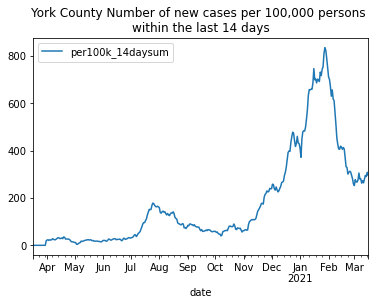

In [9]:
ph = dfy.plot(y='per100k_14daysum',x='date',title="York County Number of new cases per 100,000 persons \nwithin the last 14 days")

ph

<AxesSubplot:title={'center':'York County Cases, 14 day sum, per 100K'}, xlabel='date'>

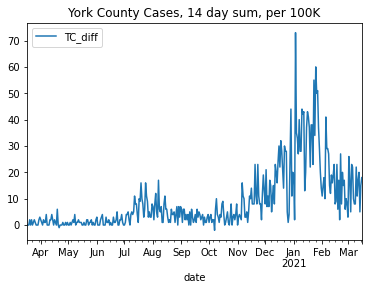

In [10]:
ph = dfy.plot(y='TC_diff',x='date',title="York County Cases, 14 day sum, per 100K")
ph

In [13]:
TOOLTIPS = [
 #   ("index", "$index"),
 #   ("date:", "$x{%F %T}"),
    ("date:", "@date{%F}"),
    ("cases/7d/100k:","@per100k_7daysum"),
    ("cases/14d/100k:","@per100k_14daysum"),
 #   ("(x,y)", "($x, $y)"),
]

vmax = (int(dfy['per100k_14daysum'].max() / 40 )+2)*40 # 

#bokeh.plotting.output_file('docs/YorkCountyCovidMetric_plot.html', mode='inline')

per100k_14daysum=bokeh.plotting.figure( tooltips=TOOLTIPS, x_axis_type='datetime')
p=bokeh.plotting.figure( x_axis_type='datetime',y_range=(0,vmax),
#                        tooltips=TOOLTIPS,formatters={"$x": "datetime"},
                        title="{} Number of new cases per 100,000 persons within the last 14 days".format(loi))

p.add_layout(bokeh.models.Title(
    text="Code: https://github.com/drf5n/YCSD_covid_metrics", text_font_style="italic"), 'above')

p.add_layout(bokeh.models.Title(
    text="https://drf5n.github.io/YCSD_covid_metrics/YorkCountyCovidMetric_plot.html", text_font_style="italic"), 'above')


hth = bokeh.models.HoverTool(tooltips=TOOLTIPS,
                             formatters={"$x": "datetime",
                                        "@date": "datetime"
                                        },
                             mode='vline',
                            )

print(hth)
print(hth.formatters)
p.add_tools(hth)
#hover = p.select(dict(type=bokeh.models.HoverTool))


#hover(tooltips=TOOLTIPS,
#)

metric_span = 7

if metric_span == 14: 
    p.add_layout(bokeh.models.BoxAnnotation(bottom=0,top=5, fill_alpha=0.4, fill_color='teal'))
    p.add_layout(bokeh.models.BoxAnnotation(bottom=5,top=20, fill_alpha=0.4, fill_color='lightgreen'))
    p.add_layout(bokeh.models.BoxAnnotation(bottom=20,top=50, fill_alpha=0.4, fill_color='yellow'))
    p.add_layout(bokeh.models.BoxAnnotation(bottom=50,top=200, fill_alpha=0.4, fill_color='orange'))
    p.add_layout(bokeh.models.BoxAnnotation(bottom=200, fill_alpha=0.4, fill_color='red'))

if metric_span == 7: 
    p.add_layout(bokeh.models.BoxAnnotation(bottom=0,top=5, fill_alpha=0.4, fill_color='teal'))
    p.add_layout(bokeh.models.BoxAnnotation(bottom=5,top=20, fill_alpha=0.4, fill_color='lightgreen'))
    p.add_layout(bokeh.models.BoxAnnotation(bottom=20,top=50, fill_alpha=0.4, fill_color='yellow'))
    p.add_layout(bokeh.models.BoxAnnotation(bottom=50,top=200, fill_alpha=0.4, fill_color='orange'))
    p.add_layout(bokeh.models.BoxAnnotation(bottom=200, fill_alpha=0.4, fill_color='red'))



#p.line(dfy['date'],dfy['per100k_14daysum'])
p.line(x='date', y='per100k_14daysum',source=dfy)
#p.title()

#?p.line

HoverTool(id='1273', ...)
{'$x': 'datetime', '@date': 'datetime'}


GlyphRenderer(id='1284', ...)

In [12]:
bokeh.plotting.show(p)

In [12]:

bokeh.plotting.save(p,filename="docs/YorkCountyCovidMetric_plot.html")

# needs geckodriver  -- have it in conda env py3plot
bokeh.io.export_png(p, filename="docs/YorkCountyCovidMetric_plot.png")



/Users/drf/anaconda3/envs/py3plot/lib/python3.7/site-packages/bokeh/io/saving.py:126: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  warn("save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN")
/Users/drf/anaconda3/envs/py3plot/lib/python3.7/site-packages/bokeh/io/saving.py:139: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  warn("save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'")


'/Users/drf/2020/Home/School/YCSD_covid_metrics/docs/YorkCountyCovidMetric_plot.png'

In [13]:
increase=(748/56.009)
inc_days=(30+31+31)

display(increase, inc_days, increase**(1/inc_days))


13.354996518416684

92

1.0285733281314142

In [14]:
TOOLTIPS = [
 #   ("index", "$index"),
 #   ("date:", "$x{%F %T}"),
    ("date:", "@date{%F}"),
    ("cases/d/100k:","@per100k_1daymean"),    
    ("cases/d/100k_7d:","@per100k_7daymean"),
    ("cases/d/100k_14d:","@per100k_14daymean"),
    ("cases/d/100k_28d:","@per100k_28daymean"),
 #   ("(x,y)", "($x, $y)"),
]

vmax = (int(dfy['per100k_7daysum'].max() / 40 )+2)*40/7 # 

#bokeh.plotting.output_file('docs/YorkCountyCovidMetric_per_day_plot.html', mode='inline')
#per100k_7daysum=bokeh.plotting.figure( tooltips=TOOLTIPS, x_axis_type='datetime')
pp=bokeh.plotting.figure( x_axis_type='datetime',y_range=(0,vmax),
#                        tooltips=TOOLTIPS,formatters={"$x": "datetime"},
                        title="{} Average Number of new cases per 100,000 persons over the last 7, 14 or 28 days".format(loi))

pp.add_layout(bokeh.models.Title(
    text="Code: https://github.com/drf5n/YCSD_covid_metrics", text_font_style="italic"), 'above')

pp.add_layout(bokeh.models.Title(
    text="https://drf5n.github.io/YCSD_covid_metrics/YorkCountyCovidMetric_per_day_plot.html", text_font_style="italic"), 'above')


hth = bokeh.models.HoverTool(tooltips=TOOLTIPS,
                             formatters={"$x": "datetime",
                                        "@date": "datetime"
                                        },
                             mode='mouse',
                            )

print(hth)
print(hth.formatters)
pp.add_tools(hth)
#hover = p.select(dict(type=bokeh.models.HoverTool))


#hover(tooltips=TOOLTIPS,
#)

pp.add_layout(bokeh.models.BoxAnnotation(bottom=0,top=10/7, fill_alpha=0.4, fill_color='blue'))
pp.add_layout(bokeh.models.BoxAnnotation(bottom=10/7,top=49/7, fill_alpha=0.4, fill_color='yellow'))
pp.add_layout(bokeh.models.BoxAnnotation(bottom=50/7,top=100/7, fill_alpha=0.4, fill_color='orange'))
pp.add_layout(bokeh.models.BoxAnnotation(bottom=100/7, fill_alpha=0.4, fill_color='red'))

pp.circle(x='date', y='per100k_1daymean',source=dfy,color='black',legend_label="Daily")
pp.line(x='date', y='per100k_7daymean',source=dfy,color="black",legend_label="/7d")
pp.line(x='date', y='per100k_14daymean',source=dfy,color='blue',legend_label="/14d")
pp.line(x='date', y='per100k_28daymean',source=dfy,color='red',legend_label="/28d")


#p.title()

bokeh.plotting.show(pp)

#?p.line

HoverTool(id='1642', ...)
{'$x': 'datetime', '@date': 'datetime'}


In [15]:

print(bokeh.plotting.save(pp,filename="docs/YorkCountyCovidMetric_per_day_plot.html"))

# needs geckodriver  -- have it in conda env py3plot
bokeh.io.export_png(pp, filename="docs/YorkCountyCovidMetric_per_day_plot.png")


/Users/drf/anaconda3/envs/py3plot/lib/python3.7/site-packages/bokeh/io/saving.py:126: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  warn("save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN")
/Users/drf/anaconda3/envs/py3plot/lib/python3.7/site-packages/bokeh/io/saving.py:139: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  warn("save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'")


/Users/drf/2020/Home/School/YCSD_covid_metrics/docs/YorkCountyCovidMetric_per_day_plot.html


'/Users/drf/2020/Home/School/YCSD_covid_metrics/docs/YorkCountyCovidMetric_per_day_plot.png'

In [16]:
#?bokeh.plotting.save